In [1]:
import pandas as pd
import numpy as np
import requests
import datetime
import re
from bs4 import BeautifulSoup

In [2]:
url = "https://en.wikipedia.org/wiki/2020_coronavirus_outbreak_in_the_United_States"

page = requests.get(url)
soup = BeautifulSoup(page.content, "html.parser")

In [3]:
columns = ["date", "deaths", "recoveries", "actives", "#cases", "#deaths"]

In [4]:
rows = []

paren_pattern = re.compile(r"\(.*\)")
comma_pattern = re.compile(r",")

# Start horrendous spaghetti code for getting data from Wikipedia
# td with class 'bb-lr' has deaths (background-color: #A50026), recoveries (SkyBlue), and actives (Tomato) in divs

for i, trow in enumerate(soup.find_all("tr", **{"class": "mw-collapsible"})):
    
    # insure all dates are represented
    
    date_field = trow.find_all("td")[0]
    
    if date_field.text == "⋮":
        continue
        
    row_date = datetime.datetime.strptime(date_field.text, "%Y-%m-%d")
    
    if i == 0:
        date = row_date
    else:
        date += datetime.timedelta(days=1)
  
    while date < row_date:
        temp_row = [date, np.nan, np.nan, np.nan, np.nan, np.nan]
        rows.append(dict(zip(columns, temp_row)))
        date += datetime.timedelta(days=1)
    
    # end insure all dates
    
    # pull out data
        
    row = {}
    row_data = []
    
    for tag in trow.find_all("td"):
        if "bb-lr" in tag["class"]:
            # get histogram data
            for div in tag.find_all("div"):
                if "#A50026" in div["style"]:
                    row[columns[1]] = div["title"]
                elif "SkyBlue" in div["style"]:
                    row[columns[2]] = div["title"]
                elif "Tomato" in div["style"]:
                    row[columns[3]] = div["title"]
        else:
            # or add data in order of processing
            row_data.append(tag.text)
            
    # match ordered data with column names and fuse together dicts
    row = {**dict(zip(columns[0:1] + columns[-2:], row_data)), **row}
    # replace date string with datetime object
    row[columns[0]] = row_date
    
    # convert strings to integers and replace any not found data
    for column in columns:
        if "date" in column:
            continue
            
        if column not in row.keys() or row[column].strip() == "":
            row[column] = 0
            
        if type(row[column]) is str:
            row[column] = paren_pattern.sub("", row[column])
            row[column] = comma_pattern.sub("", row[column])
            row[column] = row[column].strip()
            row[column] = int(row[column])

    rows.append(row)
    
    # end pull out data
    
    date = row_date

In [5]:
df = pd.DataFrame(rows)

In [6]:
# forward fill data from previous days to days with no update
df = df.fillna(method="ffill")

df.head()
df.tail()

,date,#cases,#deaths,deaths,recoveries,actives
91,2020-04-21,801228.0,40079.0,40079.0,82923.0,678226.0
92,2020-04-22,830274.0,42198.0,42198.0,84050.0,704026.0
93,2020-04-23,862605.0,44039.0,44039.0,85922.0,732644.0
94,2020-04-24,898743.0,46101.0,46102.0,110432.0,742208.0
95,2020-04-25,934219.0,47930.0,47930.0,118162.0,768127.0


In [7]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

(array([737456., 737470., 737485., 737499., 737516., 737530.]),
 <a list of 6 Text major ticklabel objects>)

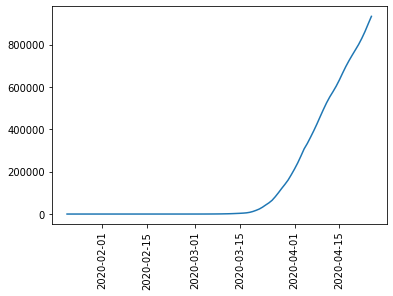

In [8]:
plt.plot(df["date"], df["#cases"])
plt.xticks(rotation=90)

In [9]:
last_15_days = df.tail(15)
last_15_days

,date,#cases,#deaths,deaths,recoveries,actives
81,2020-04-11,525436.0,20446.0,20443.0,30453.0,474540.0
82,2020-04-12,553493.0,21939.0,21936.0,32634.0,498923.0
83,2020-04-13,578178.0,23401.0,23398.0,36948.0,517832.0
84,2020-04-14,604165.0,25779.0,25776.0,38820.0,539569.0
85,2020-04-15,633630.0,28217.0,28214.0,48708.0,556708.0
86,2020-04-16,665706.0,30358.0,30355.0,57754.0,577597.0
87,2020-04-17,696621.0,32438.0,32435.0,60510.0,603676.0
88,2020-04-18,724705.0,34181.0,34178.0,68285.0,622242.0
89,2020-04-19,750718.0,35815.0,35812.0,71012.0,643894.0
90,2020-04-20,775850.0,37455.0,37455.0,72389.0,666006.0


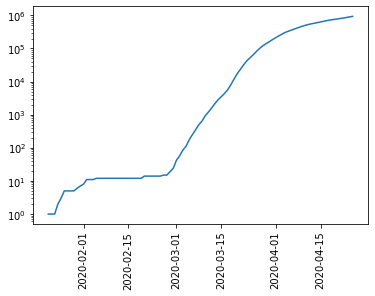

In [21]:
import numpy as np

plt.plot(df["date"], df["#cases"])
plt.xticks(rotation=90)
plt.yscale("log", basey=10)